# 663 Final Project: NUTS Algorithm
## Stephanie Brown, Liz Lorenzi, Jody Wortman
### April 6, 2016

Abstract: Our project aims to implement and explore the No-U-Turn Sampler (NUTS), an algorithm for adaptively setting path lengths in Hamiltonian Monte Carlo. Hamiltonian Monte Carlo (HMC) is an MCMC algorithm that uses first-order gradient information to enable faster convergence by avoiding the random walk behavior and sensitivity to correlated parameters.  Specifically, NUTS uses a recursive algorithm which eliminates the need to manually tune parameters for step size and number of steps.  We implement this algorithm and compare its posterior accuracy and computational efficiency to other MCMC methods, such as Metropolis-Hastings, Gibbs samplers, and Hamiltonian MCMC. We show examples of how the tuning parameters from HMC can result in poor posterior estimations, and how the NUTS recursive tuning results in similar or better estimation without the need for manual tuning. In addition, we implement the Efficient NUTS algorithm as well as the NUTS with Dual Averaging, to explore the speed ups available for this algorithm.


## Introduction

In a growing field of Bayesian statistics and with the increasing use of Bayesian hierarchical models, valid methods for posterior estimation are critical. Because posterior distributions for some models are impossible to calculate analytically, researchers and analysts rely on Markov Chain Monte Carlo (MCMC) when tractable posteriors are unavailable. Commonly used MCMC methods are symmetric Metropolis algorithms and Gibbs samplers. Both of these methods are simple but can take so long to converge that they are not useful. While Hamiltonian Monte Carlo (HMC) addresses some of these issues via an approach that uses a set auxiliary variables, the approach necessitates user input of tuning parameters. Because performance is dependent on these parameters, HMC is not as widely used as it could be given its benefits. This issue is addressed by an algorithm called the No U-Turn Sampler (NUTS) proposed by Hoffman and Gelman \citeyear{homan2014no}. NUTS adaptively sets these parameters so that they do not require user input. \\
In this paper, we review the background of MCMC and HMC, motivating the adaptation. We then introduce NUTS and outline its advantages. We implement the algorithm in various stages of complexity and efficiency, compare it to other common MCMC methods, explore its strengths and weaknesses, and discuss its benefits to the Bayesian statistics community.


### MCMC

MCMC methods simulate from a posterior distribution through drawing correlated samples--if the algorithm is correct and appropriate, these will converge to the target distribution \cite{neal}. These methods differ from each other--one common one is Gibbs sampling \cite{geman}, which updates conditional distributions until they all converge. However, this approach requires deriving the conditional distributions, which may not always be possible. Another approach is random walk Metropolis \cite{metropolis}, which uses likelihood ratios to either move to a new point in the posterior distribution or remain in the same place. Both methods may take a very long time to converge, however, as they both explore the parameter space in a stochastic, not necessarily efficient manner. 


### Hamiltonian Monte Carlo

Hamiltonian Monte Carlo (HMC, also called Hybrid Monte Carlo) \cite{duane, neal} is a method which uses auxiliary variables in the Monte Carlo proposals. The method has a physical motivation, where each of the auxiliary variables $r_d$ correspond to the momentum of each model variable $\theta_d$. The algorithm uses direction and gradient information to update the values. Hoffman and Gelman outline a version of HMC in their paper where a leapfrog function is used to update $r$ and $\theta$ using the leapfrog integrator. The parameter proposals are then accepted or rejected using a Metropolis algorithm \cite{metropolis}. This method can work very well and converge faster than random walk Metropolis, but its degree of success is highly dependent on choosing both the step size $\epsilon$ and the number of steps $L$. Poor choices have varying consequences from inaccuracy to lack of convergence, but they generally lead to a slow but ergodic chain \cite{homan2014no}.

### NUTS Algorithm and Advantages

Due to the issues caused by poor choices of $\epsilon$ and $L$ (though mostly $L$), Hoffman and Gelman's paper develops a method to adaptively select these parameters. The No-U-Turn Sampler eliminates the need for select the number of steps, and NUTS with dual averaging allows $\epsilon$ to also be adaptively set. The paper outlines the NUTS algorithm, then dual averaging. First, there is a naive approach, then an efficient version. We implement both and test their performance against each other and a standard Gibbs sampler and random walk Metropolis. 

## Implementation

The python implementation of the NUTS algorithm involved first coding HMC then NUTS, and finally an efficient version of NUTS which will be discussed in detail in the Optimization section. Care was taken to use functions whenever possible in order to keep code readable and efficient. Notation was kept consistent with that found in the original algorithm as written by Hoffman and Gelman.

### Hamiltonian Monte Carlo

We first implement Hamiltonian Monte Carlo, the method NUTS aims to improve. The implementation is similar to a Metropolis Hastings sampler, but incorporates the gradients of the parameters to help improve the sampler's ability to search through the posterior. This is done through the helper function Leapfrog. The below code provides an example of HMC for a simple linear regression (more information in the comparison section).

In [2]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

n=50

true_beta = np.transpose(stats.norm.rvs(loc=0,scale=1,size=2))
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = np.transpose(np.array([np.ones(n),stats.norm.rvs(loc=0,scale=1,size=n)]))
y = np.random.normal(x.dot(true_beta), np.sqrt(1/true_phi))


beta0 = stats.norm.rvs(loc=0,scale=1,size=2)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0

print(true_beta,true_phi)
print(theta0)

[ 3.14396796  0.94551326] [ 2.22019157]
[ 1.10278422 -0.46650268  0.73039525]


In [3]:
import warnings
warnings.filterwarnings("ignore")


In [6]:
def leapfrog(y,x,theta, r, eps):
    n = y.shape[0]
    gradients = np.hstack([theta[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta[0:2]))-.01*theta[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta[0:2]))).dot(y-x.dot(theta[0:2]))])
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = np.hstack([theta_upd[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta_upd[0:2]))-.01*theta_upd[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta_upd[0:2]))).dot(y-x.dot(theta_upd[0:2]))])
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [7]:
def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=x.dot(theta[0:2]), scale=1/np.sqrt(theta[2])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(.01))+norm.logpdf(theta[1],loc=0,scale=1/np.sqrt(.01)) +gamma.logpdf(theta[2], a, scale=1/b)
 

In [8]:
def hamilt_mc(theta0, y,x, eps, L, M):
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=3)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        for i in range(L):
            theta_tilde, r_tilde = leapfrog(y,x,theta_tilde, r_tilde, eps) 
        if theta_tilde[2] < 0.0:
            print("reject")
            theta_tilde[2] = theta_m[m-1,2]
        alpha = min(1, np.exp(log_joint(y,x,theta_tilde)-(1/2)*r_tilde.dot(r_tilde))/np.exp(log_joint(y,x,theta_m[m-1,:])-1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            theta_m[m,:] = theta_tilde
            r_m =-r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
    return(theta_m)

In [9]:
M = 1000
eps = .005
L= 20


In [10]:
%%time
results_hmc = hamilt_mc(theta0, y,x, eps,L, M)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results_hmc[round(M/5):(M-1),0])
beta1_found = np.mean(results_hmc[round(M/5):(M-1),1])
phi_found = np.mean(results_hmc[round(M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)

truth (array([ 3.14396796,  0.94551326]), array([ 2.22019157]))
Mean after burn in we find 3.07263841989 0.88942954938 2.52510007383
CPU times: user 1.9 s, sys: 3.36 ms, total: 1.9 s
Wall time: 1.9 s


### No U-Turn Sampler

The Naive NUTS algorithm improves upon HMC and no longer requires the user to specifity the L parameter. Specification of epsilon is still needed.

In [11]:
def BuildTree_nuts(y,x,theta, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(y,x,theta,r,v*eps)
        if(np.linalg.norm(u) < np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            C_theta_prime = theta_prime
            C_r_prime = r_prime
        else:
            C_theta_prime = np.array([])
            C_r_prime = np.array([])
        if(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,C_theta_prime,C_r_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime = BuildTree_nuts(y,x,theta,r,u,v,j-1,eps)
        if(v == -1):
            theta_minus,r_minus,dash1,dash2,C_theta_primep,C_r_primep,s_primep = BuildTree_nuts(y,x,theta_minus,r_minus,u,v,j-1,eps)
        else:
            dash1,dash2,theta_plus,r_plus,C_theta_primep,C_r_primep,s_primep = BuildTree_nuts(y,x,theta_plus,r_plus,u,v,j-1,eps)
        if((theta_plus-theta_minus).dot(r_minus) > 0 and (theta_plus-theta_minus).dot(r_plus) > 0):  
            s_prime = s_prime*s_primep  
        else:
            s_prime = 0  
        C_theta_prime = np.hstack([C_theta_prime,C_theta_primep])
        C_r_prime = np.hstack([C_r_prime,C_r_primep])
        return theta_minus,r_minus,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime

In [12]:
#@jit
def nuts(theta0, y,x, eps, M):
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=3)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        C_theta = theta_m[m-1,:]
        C_r = r0
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,C_theta_prime,C_r_prime,s_prime = BuildTree_nuts(y,x,theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,C_theta_prime,C_r_prime,s_prime = BuildTree_nuts(y,x,theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                C_theta = np.hstack([C_theta,C_theta_prime])
                C_r = np.hstack([C_r,C_r_prime]) 
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1     
        index = np.random.randint(len(C_theta))
        if(index%3 ==1):
            index = index-1   
        if(index%3 ==2):
            index = index-2    
        theta_m[m,:] = [C_theta[index],C_theta[index+1],C_theta[index+2]] 
    return(theta_m)

In [13]:
M = 1000
eps = .003

In [134]:
%%time
results_nuts = nuts(theta0, y,x, eps, M)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results_nuts[round(4*M/5):(M-1),0])
beta1_found = np.mean(results_nuts[round(4*M/5):(M-1),1])
phi_found = np.mean(results_nuts[round(4*M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)


truth (array([ 0.91616003, -0.16869099]), array([ 4.31304656]))
Mean after burn in we find 0.974492664173 -0.265827953667 4.73119148469
CPU times: user 8min 9s, sys: 1.2 s, total: 8min 10s
Wall time: 8min 12s


## Optimization

The aim of NUTS addresses key efficiency issues in the Hamiltonian Monte Carlo method. HMC is limited by its need of tuning of the step sizes ($\epsilon$) and number of steps($L$), typically requiring multiple runs to find the correct parameter values. In addition, Hoffman and Gelman provide additional improvements in the NUTS algorithm to improve the efficiency.


### Efficient No-U-Turn Sampler

The original NUTS algorithm takes $2^j -1$ evaluations of the log likelihood and its gradient, where $j$ is the number of times we call BuildTree (see Appendix for more information on algorithms). In addition, there are $O(2^j)$ operations to determine when to stop doubling. When implemented, the most costly computational aspect of the original NUTS algorithm is the computation of the log joint distribution and its gradient. This results in an algorithm that has similar computational complexity to the original HMC. Another computationally costly aspect of the original NUTS is the storage of the $2^j$ position and momentum vectors, requiring a lot of memory.  Efficient NUTS aims to to solve these issues in the following ways. First, we change the transition kernel to produce larger jumps than the simple uniform sampling. This kernel has a memory-efficient implementation, reducing the number of position and momentum vectors stored to $O(j)$ instead of $O(2^j)$ Second, they aim to find a stopping criterion in the final doubling iteration to avoid wasting computation to build a set that won't be used. This is done by breaking out of the recursion when they encounter a zero for the stop indicator $s$.
  


In [14]:
def BuildTree_Eff(y,x,theta, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(y,x,theta,r,v*eps)
        if(u <= np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree_Eff(y,x,theta,r,u,v,j-1,eps)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep = BuildTree_Eff(y,x,theta_minus,r_minus,u,v,j-1,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep = BuildTree_Eff(y,x,theta_plus,r_plus,u,v,j-1,eps)
            p = np.exp(np.log(n_primep)-np.log(n_prime+n_primep))
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime

In [15]:
def nuts_eff(theta0, y,x, eps, M):
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=3)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime = BuildTree_Eff(y,x,theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree_Eff(y,x,theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
    return(theta_m)

In [16]:
M = 1000
eps = .005

In [54]:
%%time
results_enuts = nuts_eff(theta0, y,x, eps, M)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results_enuts[round(4*M/5):(M-1),0])
beta1_found = np.mean(results_enuts[round(4*M/5):(M-1),1])
phi_found = np.mean(results_enuts[round(4*M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)


truth (array([ 0.88218677,  1.48198383]), array([ 0.76282666]))
Mean after burn in we find 0.92242308868 1.50756296001 0.752564739169
CPU times: user 2min 43s, sys: 440 ms, total: 2min 43s
Wall time: 2min 44s


### No-U-Turn Sampler with Dual Averaging

NUTS and Efficient NUTS addresses the issue of choosing the number of Leapfrog steps, $L$. NUTS with Dual Averaging aims to take this a step further to also adaptively tuning $\epsilon$, the step size parameter. The Dual Averaging scheme is initially motivated by work of \cite{robbins} where they propose a vanishing adaptation algorithm for MCMC using stochastic approximation. 

...may be removing this section


### Further Speedups with Cython and Parrallelization

For further improvements, we look to the power of Python and its ability to compile python code to C. Specifically, we use the Cython capabilities to convert our working functions to C files for even further optimality.  This speedup results in a $10\%$ improvement. Although some speedup can be gained, due to the complex nature of our code and minimal use of loops, Cython does not greatly decrease runtime.



In [18]:
%load_ext cython

In [19]:
%%cython -a
import cython
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import gamma


@cython.boundscheck(False)
@cython.wraparound(False)
def leapfrog(y,x,theta,double[:] r,double eps):
    cdef int a,n
    cdef double b
    a = 3
    b = 2.0
    n = y.shape[0]
    gradients = np.hstack([theta[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta[0:2]))-.01*theta[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta[0:2]))).dot(y-x.dot(theta[0:2]))])
    r_upd = r + 0.5*eps*gradients
    theta_upd = theta + eps * r_upd
    gradients = np.hstack([theta_upd[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta_upd[0:2]))-.01*theta_upd[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta_upd[0:2]))).dot(y-x.dot(theta_upd[0:2]))])
    r_upd += 0.5*eps*gradients
    return theta_upd, r_upd
def log_joint(y, x, theta): 
    cdef int n
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=x.dot(theta[0:2]), scale=1/np.sqrt(theta[2])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(.01))+norm.logpdf(theta[1],loc=0,scale=1/np.sqrt(.01))+gamma.logpdf(theta[2],3, scale=0.5) 
def BuildTree(y,x,theta, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(y,x,theta,r,v*eps)
        if(u <= np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(y,x,theta,r,u,v,j-1,eps)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep = BuildTree(y,x,theta_minus,r_minus,u,v,j-1,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep = BuildTree(y,x,theta_plus,r_plus,u,v,j-1,eps)  
            p = np.exp(np.log(n_primep)-np.log(n_prime+n_primep))
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime

def NUTS_Eff(theta0, y,x, eps, int M):
    #cdef double theta_m[500][3]
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    cdef int m,s,j,v_j
    cdef double u,p,unif,n,n_prime
    #cdef double r0[3]
    #cdef double r_minus[3]
    #cdef double r_plus[3]
    #cdef double theta_minus[3]
    #cdef double theta_plus[3]
    #cdef double dash1[3]
    #cdef double dash2[3]
    for m in range(1,M):
        r0 = stats.norm.rvs(size=3)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        theta_m[m,:] = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        n = 1
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime = BuildTree(y,x,theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(y,x,theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
    return(theta_m)

In [ ]:
M = 500
eps = .005

In [ ]:
%%time
results = NUTS_Eff(theta0, y,x, eps, M)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results[round(4*M/5):(M-1),0])
beta1_found = np.mean(results[round(4*M/5):(M-1),1])
phi_found = np.mean(results[round(4*M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)

This led us to consider running our algorithm using multiple chains that are run simultaneously with ProcessPoolExecutor or multiprocessing.  Running multiple chains gives us simulations from different initial values, and saves time due to parallelization.  We can then compare results from averaging across the values found by each of the chains after a burn in period to the results from a run of a single, longer chain.  This allows us to generate the same effective sample size using either multiple shorter chains or a single longer chain.  Holding effective sample size constant, the speedup from using four chains instead of one is quite substantial. 

In [ ]:
def NUTS_Eff(theta0, y,x, eps, M):
    theta_m = np.zeros((M,3))
    theta_m[0,:] = theta0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=3)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime = BuildTree(y,x,theta_minus,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree(y,x,theta_plus,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
    return(theta_m)

In [20]:
from concurrent.futures import ProcessPoolExecutor
def f(theta0, y,x, eps, M):
    result = NUTS_Eff(theta0, y,x, eps, M)
    return result
def f_(args):
    return f(*args)

In [21]:
M = 1600  #4*(1600-100 for burn in) gives sample of 7,500 
eps = .005
#Initialize four starting values for theta, then run NUTS in parallel
beta0 = stats.norm.rvs(loc=0,scale=1,size=2)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])
beta1 = stats.norm.rvs(loc=0,scale=1,size=2)
phi1 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta1 = np.hstack([beta1, phi1])
beta2 = stats.norm.rvs(loc=0,scale=1,size=2)
phi2 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta2 = np.hstack([beta2, phi2])
beta3 = stats.norm.rvs(loc=0,scale=1,size=2)
phi3 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta3 = np.hstack([beta3, phi3])
xs = np.array([theta0, y,x, eps, M, theta1, y,x, eps, M, theta2, y,x, eps, M, theta3, y,x, eps, M])
chunks = np.array_split(xs, xs.shape[0]//(5))

In [ ]:
%%time
njobs = 4
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.map(f_,chunks)  

In [ ]:
listy = list(res)

In [ ]:
res1 = listy[0]
res2 = listy[1]
res3 = listy[2]
res4 = listy[3]
beta0_found = 0.25*(np.mean(res1[100:M-1,0])+np.mean(res2[100:M-1,0])+np.mean(res3[100:M-1,0])+np.mean(res4[100:M-1,0]))
beta1_found = 0.25*(np.mean(res1[100:M-1,1])+np.mean(res2[100:M-1,1])+np.mean(res3[100:M-1,1])+np.mean(res4[100:M-1,1]))
phi_found = 0.25*(np.mean(res1[100:M-1,2])+np.mean(res2[100:M-1,2])+np.mean(res3[100:M-1,2])+np.mean(res4[100:M-1,2]))
print("truth", (true_beta, true_phi))
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)

In [ ]:
from multiprocessing import cpu_count, Pool

In [ ]:
%%time
pool = Pool()
res = pool.map(f_,chunks)
pool.close()

In [ ]:
listy = list(res)

In [ ]:
res1 = listy[0]
res2 = listy[1]
res3 = listy[2]
res4 = listy[3]
beta0_found = 0.25*(np.mean(res1[100:M-1,0])+np.mean(res2[100:M-1,0])+np.mean(res3[100:M-1,0])+np.mean(res4[100:M-1,0]))
beta1_found = 0.25*(np.mean(res1[100:M-1,1])+np.mean(res2[100:M-1,1])+np.mean(res3[100:M-1,1])+np.mean(res4[100:M-1,1]))
phi_found = 0.25*(np.mean(res1[100:M-1,2])+np.mean(res2[100:M-1,2])+np.mean(res3[100:M-1,2])+np.mean(res4[100:M-1,2]))
print("truth", (true_beta, true_phi))
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)

## Testing: Comparison to other MCMC methods

To see how well our method works in comparison to other MCMC algorithms, we tested different MCMC samplers using the same simulation cases. We begin by using a simple example with linear regression. We run all of the methods for the same length, 1000 iterations, so that we are able to compare how well each sampler finds the posterior after the same number of samples.


$$ y_i \sim N(\beta_0 + \beta_1 X_i, 1/\phi) $$
$$ \beta_0 \sim N(0, 1/\tau) $$
$$ \beta_1 \sim N(0, 1/\tau) $$
$$ \phi \sim Gam(a, b) $$
Let $ \theta = (\beta_0, \beta_1, \phi) $

### Posterior Estimation

We first begin with comparing the posterior estimation of the three parameters with respect to the true $\theta$ used in simulating the data. The first plots display the results from a Metropolis sampler. We see from the trace plots that the sampler has a difficult time finding the true parameters. Though the results are not poor, the problematic random walk behavior of the Metropolis algorithm is displayed in this example.

In [70]:
import time
n=1000
lam=np.zeros(n)
gam=np.zeros(n)
alpha=np.zeros(n)
beta=np.zeros(n)
lam[0]=.5
gam[0]=.5
alpha[0]=0
beta[0]=0


a=1
b=1
x1 = x[:,1]


In [73]:
def update_phi(lam_star, prev_phi, prev_alph, prev_beta):
    r1=sum(norm.logpdf(y,  loc=prev_alph+prev_beta*x1, scale=1/np.sqrt(lam_star)))+gamma.logpdf(lam_star, a, scale=b)
    r2=sum(norm.logpdf(y,  loc=prev_alph+prev_beta*x1, scale=1/np.sqrt(prev_phi)))+gamma.logpdf(prev_phi, a, scale=b)
    log_rl=r1-r2
    if np.exp(log_rl)>np.exp(meas) and m_lam_star>0:
        new_phi=lam_star
    else:
        new_phi=lam[i-1]
    return(new_phi)

def update_alpha(alpha_star, prev_phi, prev_alpha, prev_beta):
    a1=sum(norm.logpdf(y, loc=alpha_star+prev_beta*x1, scale=1/np.sqrt(prev_phi)))+norm.logpdf(alpha_star, 0, 10)
    a2=sum(norm.logpdf(y, loc=prev_alpha+prev_beta*x1, scale=1/np.sqrt(prev_phi)))+norm.logpdf(prev_alpha, 0, 10)
    log_ra=a1-a2
    if np.exp(log_ra)>np.exp(meas):
        new_alpha=alpha_star
    else:
        new_alpha=prev_alpha
    return(new_alpha)

def update_beta(beta_star, prev_phi, prev_alpha, prev_beta):
    b1=sum(norm.logpdf(y, loc=prev_alpha+beta_star*x1, scale=1/np.sqrt(prev_phi)))+norm.logpdf(beta_star, 0, 10)
    b2=sum(norm.logpdf(y, loc=prev_alpha+prev_beta*x1, scale=1/np.sqrt(prev_phi)))+norm.logpdf(prev_beta, 0, 10)    
    log_rb=b1-b2
    if np.exp(log_rb)>np.exp(meas):
        new_beta=beta_star
    else:
        new_beta=prev_beta
    return(new_beta)

In [74]:
start = time.clock()
for i in range(1, n):
    alpha_star=np.random.normal(alpha[i-1], 2)
    beta_star=np.random.normal(beta[i-1], 2)
    m_lam_star=np.random.normal(gam[i-1], 3)
    if(m_lam_star>0):
        lam_star=m_lam_star
    else:
        lam_star=lam[i-1]
        
    meas=math.log(np.random.uniform(0,1))    
    
    lam[i]=update_phi(lam_star, lam[i-1], alpha[i-1], beta[i-1])
    alpha[i]=update_alpha(alpha_star, lam[i-1], alpha[i-1], beta[i-1])
    beta[i]=update_beta(beta_star, lam[i-1], alpha[i-1], beta[i-1])

dt_mh_1000 = time.clock() - start
print('Time:', dt_mh_1000)

Time: 2.3338129999999637


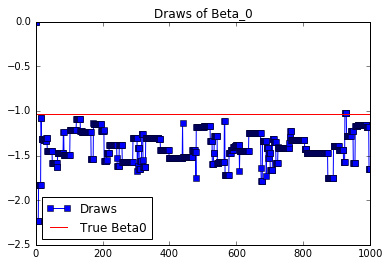

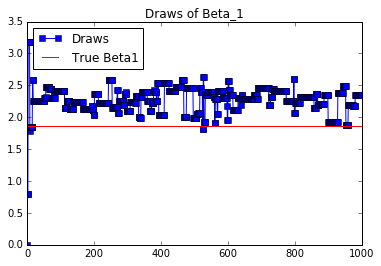

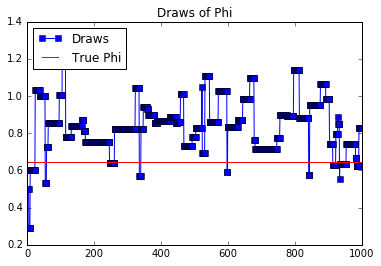

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline


fig1 = plt.figure()
plt.plot(alpha, c='b', marker="s", label='Draws')
plt.axhline(true_beta[0], c="r", label="True Beta0")
plt.title("Draws of Beta_0")
plt.legend(loc='lower left')
plt.show()
fig1.savefig('beta0s_hmc.png')

fig2 = plt.figure()
plt.plot(beta, c='b', marker="s", label='Draws')
plt.axhline(true_beta[1], c="r", label="True Beta1")
plt.title("Draws of Beta_1")
plt.legend(loc='upper left')
plt.show()
fig2.savefig('beta1s_hmc.png')

fig3 = plt.figure()
plt.plot(lam, c='b', marker="s", label='Draws')
plt.axhline(true_phi, c="r", label="True Phi")
plt.title("Draws of Phi")
plt.legend(loc='upper left')
plt.show()
fig3.savefig('phis_hmc.png')


Next, we compare the posterior estimation of $\theta$ to using Hamiltonian Monte Carlo. Finding the correct parameters for the run, ($\epsilon$, and $L$), took a few tries until we found posterior means that are similar to the truth. We see in the trace plots below that the runs tended to be quite sticky. This could be due to an $\epsilon$ that is too small or an incorrectly specified $L$. One run of this sampler is similar in run time to the Metropolis algorithm, only requiring a few seconds. Though, it requires more iterations of each run in order to find the optimal tuning parameters. 

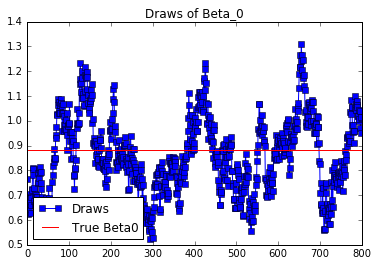

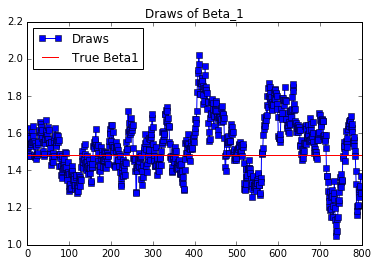

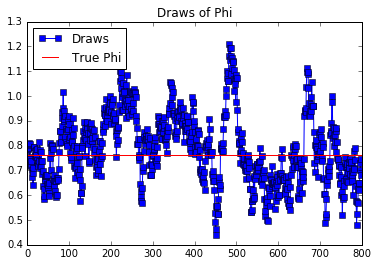

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
beta0s = results_hmc[round(M/5):(M-1),0]
beta1s = results_hmc[round(M/5):(M-1),1]
phis = results_hmc[round(M/5):(M-1),2]

fig1 = plt.figure()
plt.plot(beta0s, c='b', marker="s", label='Draws')
plt.axhline(true_beta[0], c="r", label="True Beta0")
plt.title("Draws of Beta_0")
plt.legend(loc='lower left')
plt.show()
fig1.savefig('beta0s_hmc.png')

fig2 = plt.figure()
plt.plot(beta1s, c='b', marker="s", label='Draws')
plt.axhline(true_beta[1], c="r", label="True Beta1")
plt.title("Draws of Beta_1")
plt.legend(loc='upper left')
plt.show()
fig2.savefig('beta1s_hmc.png')

fig3 = plt.figure()
plt.plot(phis, c='b', marker="s", label='Draws')
plt.axhline(true_phi, c="r", label="True Phi")
plt.title("Draws of Phi")
plt.legend(loc='upper left')
plt.show()
fig3.savefig('phis_hmc.png')


We next compare the posterior estimation of the NUTS implementation. With the NUTS implementation, we do not need to tune the number of Leapfrog steps, $L$. However, tuning $\epsilon$ is still necessary. We see that NUTS does the best job thus far at finding the true parameter and not getting overly stuck in  areas of the posterior. 

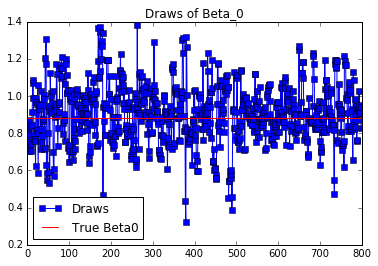

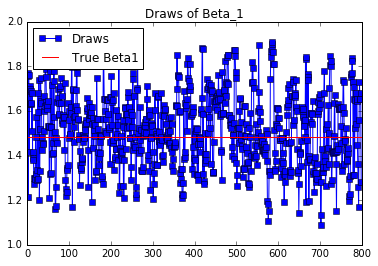

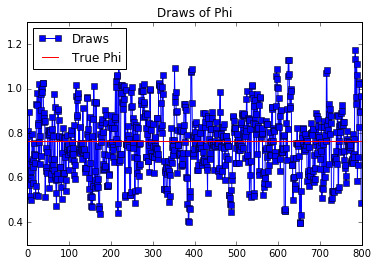

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
beta0s = results_nuts[round(1*M/5):(M-1),0]
beta1s = results_nuts[round(1*M/5):(M-1),1]
phis = results_nuts[round(1*M/5):(M-1),2]


fig1 = plt.figure()
plt.plot(beta0s, c='b', marker="s", label='Draws')
plt.axhline(true_beta[0], c="r", label="True Beta0")
plt.title("Draws of Beta_0")
plt.legend(loc='lower left')
plt.show()
fig1.savefig('beta0s_nuts.png')

fig2 = plt.figure()
plt.plot(beta1s, c='b', marker="s", label='Draws')
plt.axhline(true_beta[1], c="r", label="True Beta1")
plt.title("Draws of Beta_1")
plt.legend(loc='upper left')
plt.show()
fig2.savefig('beta1s_nuts.png')

fig3 = plt.figure()
plt.plot(phis, c='b', marker="s", label='Draws')
plt.axhline(true_phi, c="r", label="True Phi")
plt.title("Draws of Phi")
plt.legend(loc='upper left')
plt.show()
fig3.savefig('phis_nuts.png')


Lastly, we test the Efficient NUTS algorithm to see whether any improvements are found for posterior estimation.  The results are very similar to the NUTS algorithm, with good mixing and little autocorrelation among the samples. The real benefit of the Efficient NUTS algorithm is the time. Reducing the runtime from the NUTS algorithm by half for this example (see time stamps from runs in Implementation).

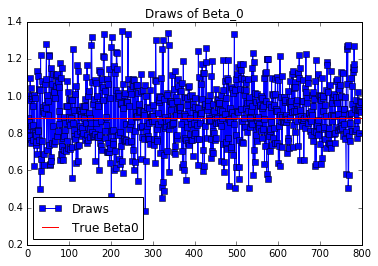

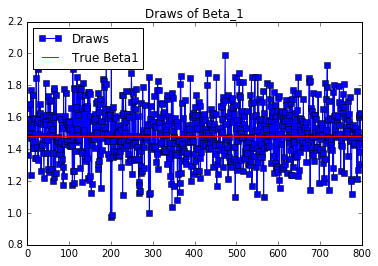

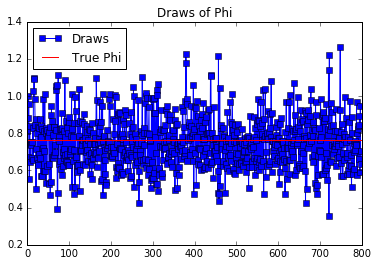

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
beta0s = results_enuts[round(1*M/5):(M-1),0]
beta1s = results_enuts[round(1*M/5):(M-1),1]
phis = results_enuts[round(1*M/5):(M-1),2]


fig1 = plt.figure()
plt.plot(beta0s, c='b', marker="s", label='Draws')
plt.axhline(true_beta[0], c="r", label="True Beta0")
plt.title("Draws of Beta_0")
plt.legend(loc='lower left')
plt.show()
fig1.savefig('beta0s_nuts.png')

fig2 = plt.figure()
plt.plot(beta1s, c='b', marker="s", label='Draws')
plt.axhline(true_beta[1], c="r", label="True Beta1")
plt.title("Draws of Beta_1")
plt.legend(loc='upper left')
plt.show()
fig2.savefig('beta1s_nuts.png')

fig3 = plt.figure()
plt.plot(phis, c='b', marker="s", label='Draws')
plt.axhline(true_phi, c="r", label="True Phi")
plt.title("Draws of Phi")
plt.legend(loc='upper left')
plt.show()
fig3.savefig('phis_nuts.png')


### 250-Dimensional Mulivariate Normal

$$ p(\theta) \propto exp\{-\frac{1}{2} \theta^T A \theta\}$$
$$ A \sim Wish(df = 250, scale = I) $$

Next, we move to another example to demonstrate the benefits of using the NUTS algorithm. This example is displayed in the Hoffman and Gelman paper. They choose a target distribution of a high dimensional normal with zero mean and known precision matrix, $A$. This yields a highly correlated target distribution. We compare the Metropolis to the HMC algorithm and NUTS Efficient algorithm.

We display the first two dimensions of the posterior distribution in comparison to the first two dimensions of the true distribution. We see that the Efficient NUTS performs the best of the three methods. 

In [94]:
def leapfrog_mult(theta, A, r, eps):
    #gradients are specific to this example
    gradients = A.dot(theta)
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = A.dot(theta_upd)
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [95]:
def log_joint1(theta, A):
    #seems like this can be up to a normalizing constant so that's what i did, but otherwise that could be the issue
    return -1/2 * theta.T.dot(A).dot(theta)



In [96]:
def hamilt_mc1(theta0,A,eps,L,M):
    no_par = theta0.shape[0]
    theta_m = np.zeros((M,no_par))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=no_par)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        for i in range(L):
            theta_tilde, r_tilde = leapfrog_mult(theta_tilde,A, r_tilde, eps) 
        alpha = min(1, np.exp(log_joint1(theta_tilde,A)-(1/2)*r_tilde.dot(r_tilde))/np.exp(log_joint1(theta_m[m-1,:],A)-1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            theta_m[m,:] = theta_tilde
            r_m =-r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
    return(theta_m)

In [107]:
M = 100000
eps = .005
L= 20

A = stats.wishart.rvs(df=15, scale= np.eye(15))
#true_theta = stats.norm.rvs(scale=A,size=250)
true_theta = np.random.multivariate_normal(mean=np.zeros(15),cov=A,size=100)
#target distribution is zero-mean 250-dimensional multivariate normal with known precision
theta0 = stats.norm.rvs(size=15)


In [108]:
%%time
results = hamilt_mc1(theta0,A,eps,L,M)

CPU times: user 39.5 s, sys: 119 ms, total: 39.6 s
Wall time: 39.7 s


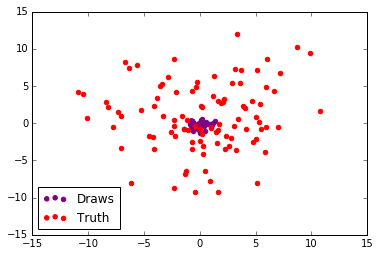

In [112]:
thinned_results = results[[x for x in range(M) if x % 1000 == 0],:]
plt.scatter(thinned_results[:,1], thinned_results[:,2], color="purple", label="Draws")
plt.scatter(true_theta[:,1], true_theta[:,2], color="red", label="Truth")
plt.legend(loc='lower left')


In [101]:
def BuildTree_mult(theta,A, r, u, v, j, eps):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog_mult(theta,A,r,v*eps)
        if(u <= np.exp(log_joint1(theta_prime,A)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(log_joint1(theta_prime,A)-(1/2)*r_prime.dot(r_prime) > u-triangle_max):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree_mult(theta,A,r,u,v,j-1,eps)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep = BuildTree_mult(theta_minus,A,r_minus,u,v,j-1,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep = BuildTree_mult(theta_plus,A,r_plus,u,v,j-1,eps) 
            p = np.exp(np.log(n_primep)-np.log(n_prime+n_primep))
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime

In [102]:
def NUTS_Mvt(theta0,A,eps,M):
    no_par = theta0.shape[0]
    theta_m = np.zeros((M,no_par))
    theta_m[0,:] = theta0
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=no_par)
        u = np.random.uniform(low=0,high=np.exp(log_joint1(theta_m[m-1,:],A)-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s=1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime = BuildTree_mult(theta_minus,A,r_minus,u,v_j,j,eps)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime = BuildTree_mult(theta_plus,A,r_plus,u,v_j,j,eps)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
    return(theta_m)

In [103]:
M = 100000
eps = 0.05

In [114]:
%%time
results_nuts = NUTS_Mvt(theta0,A,eps, M)

KeyboardInterrupt: 

In [ ]:
thinned_results = results_nuts[[x for x in range(M) if x % 1000 == 0],:]
plt.scatter(thinned_results[:,1], thinned_results[:,2], color="purple", label="Draws")
plt.scatter(true_theta[:,1], true_theta[:,2], color="red", label="Truth")
plt.legend(loc='lower left')

## Discussion

In this paper, we reviewed common approaches to MCMC, including random walk Metropolis and Hamiltonian Monte Carlo. We then introduced and implemented the No-U-Turn Sampler proposed by Hoffman and Gelman \citeyear{homan2014no}. We used a naive version and also an efficient version and tested both against the other methods. 

From our results, we see that the posterior estimation is greatly improved by the use of NUTS. In addition, the efficiency and performance of NUTS improves upon HMC greatly by eliminating the need to tune the number of Leapfrog steps, $L$. In both the simple linear regression example and the high-dimensional normal example, we show that NUTS outperforms the other methods.

The NUTS algorithm has enormous potential for any research involving Bayesian models and posterior estimation of continuous distributions. It addresses the key setbacks of HMC (the need to specify step size and number of steps), and in doing so allows for more common use and implementation. Additionally, the authors created the package PyStan so that the algorithm can be more widely used by those who cannot or choose not to write the code themselves. While we used our own code in this paper, the availability of such a package arguably increases the value of the method, as it will be accessible beyond those with the ability to execute it independently. Overall, the algorithm is a useful and flexible tool that addresses a major limitation of HMC and MCMC generally.
